Fraud Card Transaction

card_transdata.csv dataset has 1,000,000 rows and 8 columns:
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data


In [6]:
#packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest

In [2]:
#brief analysis
df = pd.read_csv("card_transdata.csv")

dfcorrs = df.corr()
dfcorrs["fraud"]

distance_from_home                0.187571
distance_from_last_transaction    0.091917
ratio_to_median_purchase_price    0.462305
repeat_retailer                  -0.001357
used_chip                        -0.060975
used_pin_number                  -0.100293
online_order                      0.191973
fraud                             1.000000
Name: fraud, dtype: float64

/var/folders/vn/c8vs9t81471f97pljhh337mh0000gp/T/ipykernel_80333/1675129750.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


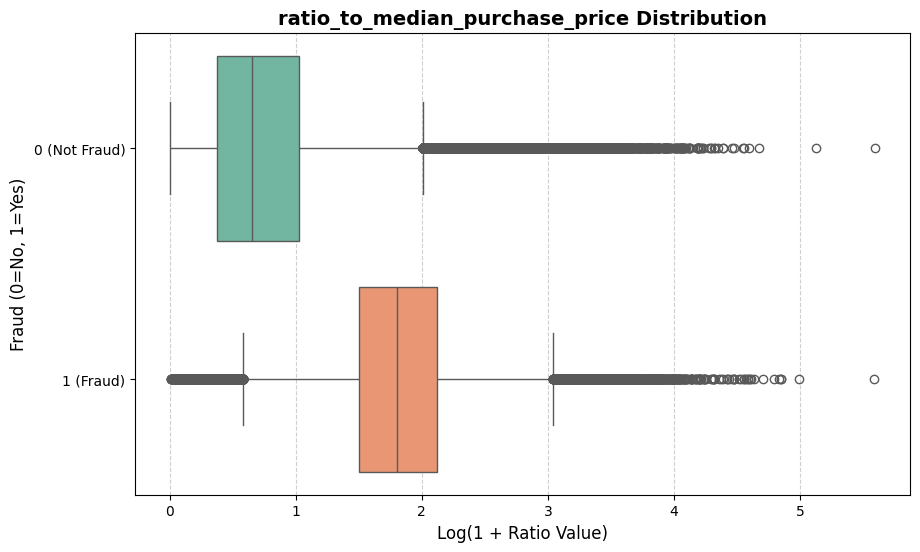

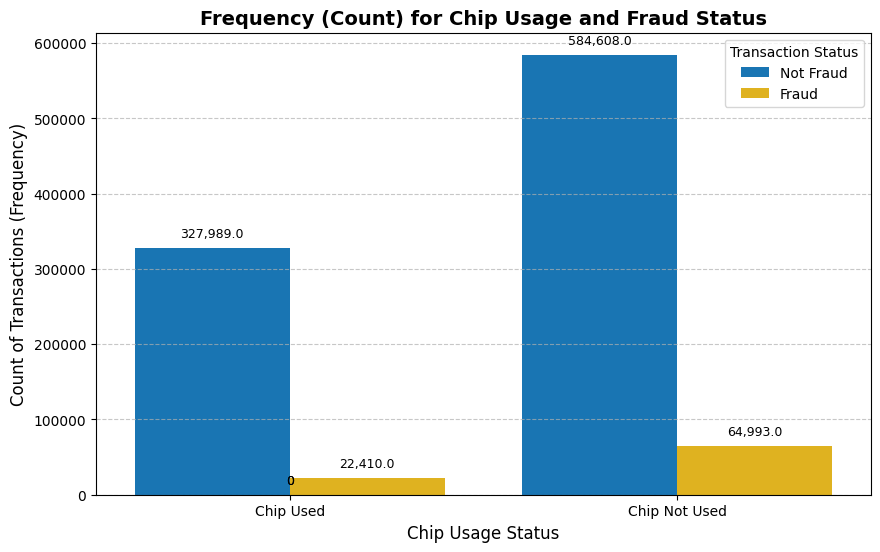

In [12]:
#EDA
feature = 'ratio_to_median_purchase_price'
df['Log_Ratio'] = np.log1p(df[feature])

plt.figure(figsize=(10, 6))

sns.boxplot(
    x=df['Log_Ratio'], 
    y=df['fraud'].astype(str), 
    orient='h', 
    palette='Set2'
)

title = feature.replace("_", " ").title()
plt.title('ratio_to_median_purchase_price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log(1 + Ratio Value)', fontsize=12)
plt.ylabel('Fraud (0=No, 1=Yes)', fontsize=12)
plt.yticks([0, 1], ['0 (Not Fraud)', '1 (Fraud)'])
plt.grid(axis='x', linestyle='--', alpha=0.6)


#bar graph used chip
df['Used_Chip_Label'] = df['used_chip'].map({0.0: 'Chip Not Used', 1.0: 'Chip Used'})
df['Fraud_Label'] = df['fraud'].map({0.0: 'Not Fraud', 1.0: 'Fraud'})
plt.figure(figsize=(10, 6))

sns.countplot(
    x='Used_Chip_Label', 
    hue='Fraud_Label', 
    data=df, 
    palette=['#007ACC', '#FFC300']
)

plt.title('Frequency (Count) for Chip Usage and Fraud Status', fontsize=14, fontweight='bold')
plt.xlabel('Chip Usage Status', fontsize=12)
plt.ylabel('Count of Transactions (Frequency)', fontsize=12)
plt.legend(title='Transaction Status', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=9)

In [3]:
binaryCol = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
df.drop_duplicates(inplace=True)

train_df, test_df = train_test_split(df,
                                     train_size=0.8,
                                     random_state=42,
                                     stratify=df['fraud'])

X_train, y_train, X_test, y_test = train_df.drop('fraud', axis=1), train_df['fraud'], test_df.drop('fraud', axis=1), test_df['fraud']

contCol = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
binaryCol = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

s = StandardScaler()
X_train_scaled_cont = s.fit_transform(X_train[contCol])
X_test_scaled_cont = s.transform(X_test[contCol])

X_train_scaled = pd.DataFrame(X_train_scaled_cont, columns=contCol, index=X_train.index)
X_train_scaled[binaryCol] = X_train[binaryCol]
X_train_scaled = X_train_scaled[X_train.columns]

X_test_scaled = pd.DataFrame(X_test_scaled_cont, columns=contCol, index=X_test.index)
X_test_scaled[binaryCol] = X_test[binaryCol]
X_test_scaled = X_test_scaled[X_test.columns]

#model training
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

svc = SVC(kernel='linear', random_state=42, class_weight='balanced', max_iter=2000)
svc.fit(X_train_scaled, y_train)

yLr = lr.predict(X_test_scaled)
print("\nLogistic Regression:")
print(classification_report(y_test, yLr, target_names=['Not Fraud (0)', 'Fraud (1)']))

ySvc = svc.predict(X_test_scaled)
print("\nSVM (SVC:")
print(classification_report(y_test, ySvc, target_names=['Not Fraud (0)', 'Fraud (1)']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Logistic Regression:
               precision    recall  f1-score   support

Not Fraud (0)       0.99      0.93      0.96    182519
    Fraud (1)       0.58      0.95      0.72     17481

     accuracy                           0.93    200000
    macro avg       0.79      0.94      0.84    200000
 weighted avg       0.96      0.93      0.94    200000


SVM (SVC:
               precision    recall  f1-score   support

Not Fraud (0)       0.99      0.10      0.19    182519
    Fraud (1)       0.10      0.99      0.17     17481

     accuracy                           0.18    200000
    macro avg       0.54      0.55      0.18    200000
 weighted avg       0.91      0.18      0.19    200000



Results of the SVC:
 TN: 18755,
 FP: 163764,
 FN: 139,
 TP: 17342
Results of Logistic Regression:
 TN: 170377,
 FP: 12142,
 FN: 909,
 TP: 16572


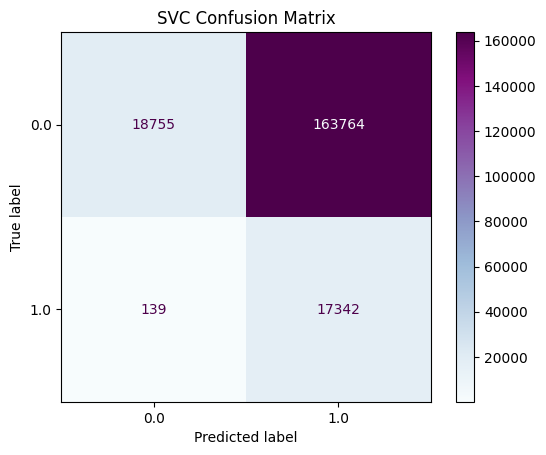

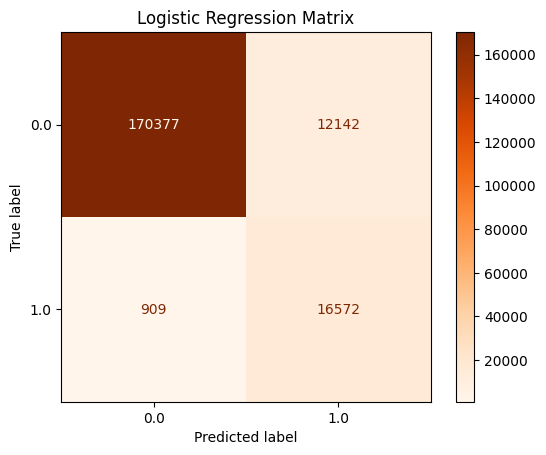

In [4]:
#confusion matrixs
ConfusionMatrixDisplay.from_predictions(y_test, ySvc, cmap  = "BuPu")
plt.title("SVC Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, yLr, cmap = "Oranges")
plt.title("Logistic Regression Matrix")

#results
tn, fp, fn, tp = confusion_matrix(y_test, ySvc).ravel()
print(f"Results of the SVC:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")
tn, fp, fn, tp = confusion_matrix(y_test, yLr).ravel()
print(f"Results of Logistic Regression:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")


Decision Tree:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00    182519
    Fraud (1)       1.00      1.00      1.00     17481

     accuracy                           1.00    200000
    macro avg       1.00      1.00      1.00    200000
 weighted avg       1.00      1.00      1.00    200000


Random Forest:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00    182519
    Fraud (1)       1.00      1.00      1.00     17481

     accuracy                           1.00    200000
    macro avg       1.00      1.00      1.00    200000
 weighted avg       1.00      1.00      1.00    200000


Decision Tree Confusion Matrix:
True Negatives (TN):  182518
False Positives (FP): 1
False Negatives (FN): 2
True Positives (TP):  17479

Random Forest Confusion Matrix:
True Negatives (TN):  182519
False Positives (FP): 0
False Negatives (FN): 5
True Positives (TP):  17476


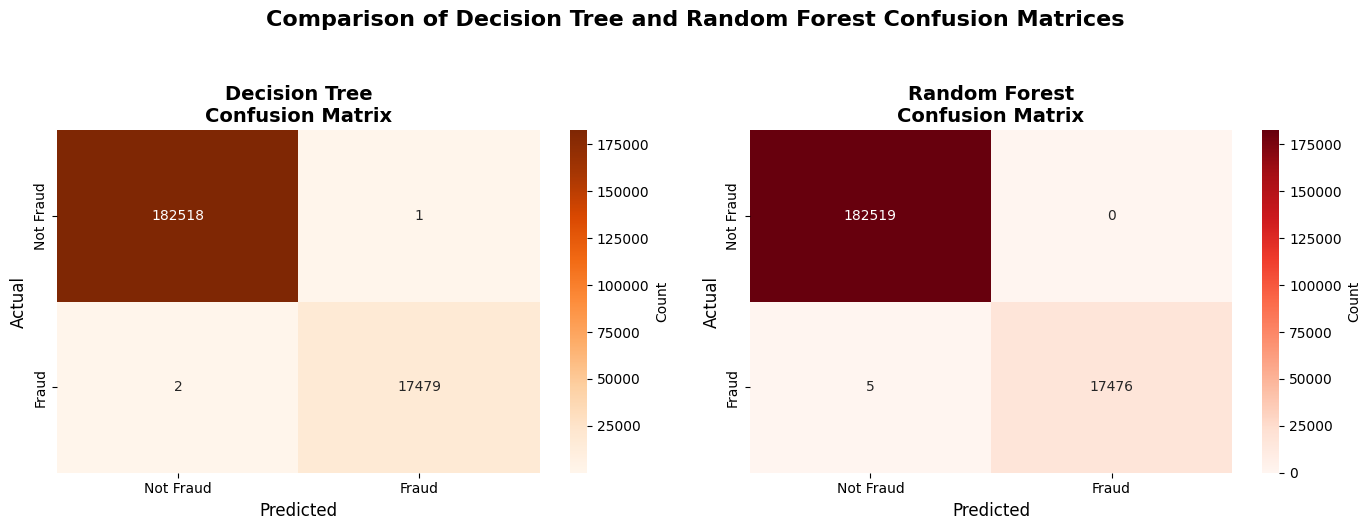


Area Under the Curve (AUC) Scores
Logistic Regression AUC: 0.9795
SVM (SVC) AUC: 0.7443
Decision Tree AUC: 0.9999
Random Forest AUC: 1.0000


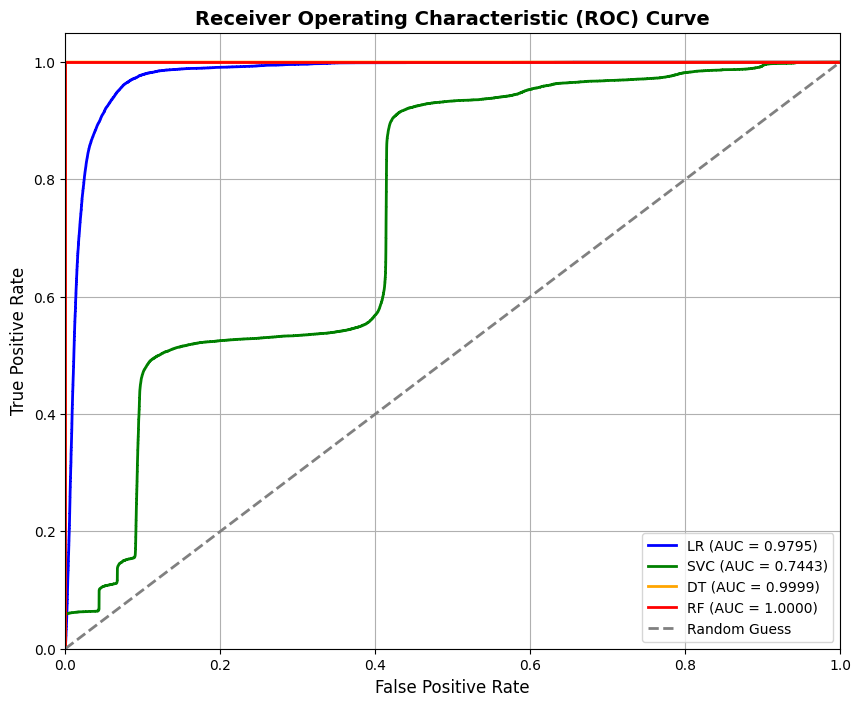

In [5]:
# Decision Tree and Random Forest
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf.fit(X_train_scaled, y_train)

yDt = dt.predict(X_test_scaled)
yRf = rf.predict(X_test_scaled)

# Classification Reports for dt and rf
print("\n" + "="*50)
print("Decision Tree:")
print(classification_report(y_test, yDt, target_names=['Not Fraud (0)', 'Fraud (1)']))

print("\nRandom Forest:")
print(classification_report(y_test, yRf, target_names=['Not Fraud (0)', 'Fraud (1)']))

# Confusion Matrices for dt and rf
cm_dt = confusion_matrix(y_test, yDt)
cm_rf = confusion_matrix(y_test, yRf)

print("\nDecision Tree Confusion Matrix:")
print(f"True Negatives (TN):  {cm_dt[0, 0]}")
print(f"False Positives (FP): {cm_dt[0, 1]}")
print(f"False Negatives (FN): {cm_dt[1, 0]}")
print(f"True Positives (TP):  {cm_dt[1, 1]}")

print("\nRandom Forest Confusion Matrix:")
print(f"True Negatives (TN):  {cm_rf[0, 0]}")
print(f"False Positives (FP): {cm_rf[0, 1]}")
print(f"False Negatives (FN): {cm_rf[1, 0]}")
print(f"True Positives (TP):  {cm_rf[1, 1]}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Decision Tree\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Random Forest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.suptitle('Comparison of Decision Tree and Random Forest Confusion Matrices', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# ROC and AUC
yLr_prob = lr.predict_proba(X_test_scaled)[:, 1]
ySvc_prob = svc.decision_function(X_test_scaled)
yDt_prob = dt.predict_proba(X_test_scaled)[:, 1]
yRf_prob = rf.predict_proba(X_test_scaled)[:, 1]

auc_lr = roc_auc_score(y_test, yLr_prob)
auc_svc = roc_auc_score(y_test, ySvc_prob)
auc_dt = roc_auc_score(y_test, yDt_prob)
auc_rf = roc_auc_score(y_test, yRf_prob)

fpr_lr, tpr_lr, _ = roc_curve(y_test, yLr_prob)
fpr_svc, tpr_svc, _ = roc_curve(y_test, ySvc_prob)
fpr_dt, tpr_dt, _ = roc_curve(y_test, yDt_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, yRf_prob)

print("\n" + "="*50)
print("Area Under the Curve (AUC) Scores")
print("="*50)
print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"SVM (SVC) AUC: {auc_svc:.4f}")
print(f"Decision Tree AUC: {auc_dt:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'LR (AUC = {auc_lr:.4f})')
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label=f'SVC (AUC = {auc_svc:.4f})')
plt.plot(fpr_dt, tpr_dt, color='orange', lw=2, label=f'DT (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'RF (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()